In [72]:
using Oceananigans
using JLD2
using CairoMakie
using Statistics
using ImageFiltering: imfilter, Kernel.gaussian
using ZipFile

In [77]:
runname = "default"
@inline function makefluxvid(runname, i=nothing)
    foldername = "../scratch/filament-instability/$runname"
    filename = "down_front_mean.jld2"
    qRifilename = "qRi.jld2"
    fluxfilename = "turbulent_flux.jld2"
    paramfilename = "parameters.jld2"
    frames, grid = jldopen("$foldername/$filename") do file
        keys(file["timeseries/t"]), file["serialized/grid"]
        end;
    xᶜᵃᵃ = xnodes(Center, grid)
    xᶠᵃᵃ = xnodes(Face, grid)
    zᵃᵃᶜ = znodes(Center, grid)
    zᵃᵃᶠ = znodes(Face, grid)
    function ψᶜᶜᶜ(uᶠᶜᶜ, wᶜᶜᶠ, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ)
        # Integrate
        Δzᵃᵃᶜ = reshape(diff(zᵃᵃᶠ), 1, length(zᵃᵃᶜ))
        Δx = xᶠᵃᵃ[2] - xᶠᵃᵃ[1]
        aᶠᶜᶜ = cumsum(uᶠᶜᶜ .* Δzᵃᵃᶜ; dims=3)

        bᶜᶜᶠ = cumsum(wᶜᶜᶠ .* Δx; dims=1)
        aᶜᶜᶜ = (circshift(aᶠᶜᶜ, (-1, 0)) .+ aᶠᶜᶜ) / 2
        bᶜᶜᶜ = (bᶜᶜᶠ[:, 1:end-1] .+ bᶜᶜᶠ[:, 2:end]) ./ 2
        return -aᶜᶜᶜ .+ bᶜᶜᶜ
    end

    file = jldopen("$foldername/$filename")
    qRifile = jldopen("$foldername/$qRifilename")
    fluxfile = jldopen("$foldername/$fluxfilename")
    
    n = Observable(1)

    frame = @lift frames[$n]


    ts = [file["timeseries/t/$f"] for f in frames] .- 1

    u = @lift file["timeseries/u_dfm/$($frame)"][:, 1, :]
    w = @lift file["timeseries/w_dfm/$($frame)"][:, 1, :]

    b = @lift file["timeseries/b_dfm/$($frame)"][:, 1, :]
    
    
    # Get the secondary cirulation streamfunction
    σ=3
    ψ = @lift imfilter(ψᶜᶜᶜ($u, $w, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ), gaussian((σ, 0), (4σ+1, 5)), "circular")
    
    uflux = @lift fluxfile["timeseries/uFLUX/$($frame)"][:, 1, :]
    vflux = @lift fluxfile["timeseries/vFLUX/$($frame)"][:, 1, :]
    wflux = @lift fluxfile["timeseries/wFLUX/$($frame)"][:, 1, :]
    bflux = @lift fluxfile["timeseries/bFLUX/$($frame)"][:, 1, :]
    q = @lift imfilter(qRifile["timeseries/q/$($frame)"][:, 1, :], gaussian((σ, 0), (4σ+1, 5)), "circular")
    q_check = @lift ifelse.($q .< 0, 1, NaN)
    invRi = @lift imfilter(qRifile["timeseries/invRi/$($frame)"][:, 1, :], gaussian((σ, 0), (4σ+1, 5)), "circular")
    invRi_check = @lift ifelse.(1/0.95 .< $invRi .< 4, 1, NaN)
    title = @lift "t = $(round(ts[$n]; digits=2))"
    
    axis_kwargs = (; xlabel="x", ylabel="z", title, limits=(-2, 0, -0.15, 0))

    fig = Figure(resolution=(1200, 800))
    fig[1, 1:4] = Label(fig, title, fontsize=20)
    axu = Axis(fig[2, 1]; title=L"\langle w'u'\rangle", axis_kwargs...)
    axv = Axis(fig[2, 3]; title=L"\langle w'v'\rangle", axis_kwargs...)
    axw = Axis(fig[3, 1]; title=L"\langle w'w'\rangle", axis_kwargs...)
    axb = Axis(fig[3, 3]; title=L"\langle w'b'\rangle", axis_kwargs...)
    
    limuv = 1e-2
    limw = 1e-1
    limb = 1
    htu = heatmap!(axu, xᶜᵃᵃ, zᵃᵃᶠ, uflux; colormap=:balance, colorrange=(-limuv, limuv))
    htv = heatmap!(axv, xᶜᵃᵃ, zᵃᵃᶠ, vflux; colormap=:balance, colorrange=(-limuv, limuv))
    htw = heatmap!(axw, xᶜᵃᵃ, zᵃᵃᶠ, wflux; colormap=:balance, colorrange=(-limw, limw))
    htb = heatmap!(axb, xᶜᵃᵃ, zᵃᵃᶠ, bflux; colormap=:balance, colorrange=(-limb, limb))
    
    for ax in [axu, axv, axw, axb]
        contour!(ax, xᶜᵃᵃ, zᵃᵃᶜ, ψ; colormap=:BrBG_10, levels=range(-0.012, 0.012, 40), alpha=1, linewidth=1)
        contour!(ax, xᶜᵃᵃ, zᵃᵃᶜ, b; color=(:black, 1), levels=range(-600, 200, 160), linewidth=1)
        #contour!(ax, xᶜᵃᵃ, zᵃᵃᶠ, invRi; color=:blue, levels=[1/0.95], alpha=0.5)
        #contour!(ax, xᶜᵃᵃ, zᵃᵃᶠ, invRi; color=:blue, levels=[1/0.25], linestyle=:dash, alpha=0.5)
        #contour!(ax, xᶜᵃᵃ, zᵃᵃᶜ, q; color=:red, levels=[0], alpha=0.5)
        #heatmap!(ax, xᶜᵃᵃ, zᵃᵃᶜ, q_check; colormap=[RGBAf(c.r, c.g, c.b, 0.1) for c in to_colormap(:reds)])
        #heatmap!(ax, xᶜᵃᵃ, zᵃᵃᶠ, invRi_check; colormap=[RGBAf(c.r, c.g, c.b, 0.1) for c in to_colormap(:blues)])
    end
    Colorbar(fig[2, 2], htu, label=L"\langle w'u'\rangle")
    Colorbar(fig[2, 4], htv, label=L"\langle w'v'\rangle")
    Colorbar(fig[3, 2], htw, label=L"\langle w'w'\rangle")
    Colorbar(fig[3, 4], htb, label=L"\langle w'b'\rangle")
    
    if i != nothing
        n[] = i
        return fig
    end
    
    vidfoldername = "output/videos/$runname/shearproduction"
    !ispath(vidfoldername) && mkpath(vidfoldername)
    w = ZipFile.Writer("$vidfoldername.zip");
    for i in 101:length(frames)
        n[] = i
        zipfile = ZipFile.addfile(w, "$(lpad(i, 4, '0')).png");
        save("$vidfoldername/$(lpad(i, 4, '0')).png", fig; resolution=(1200, 800))
        open(r -> write(zipfile, r), "$vidfoldername/$(lpad(i, 4, '0')).png")
        close(zipfile)
        rm("$vidfoldername/$(lpad(i, 4, '0')).png")
    end
    close(file)
    rm("$vidfoldername")
    close(w)
    fig
end

makefluxvid (generic function with 2 methods)

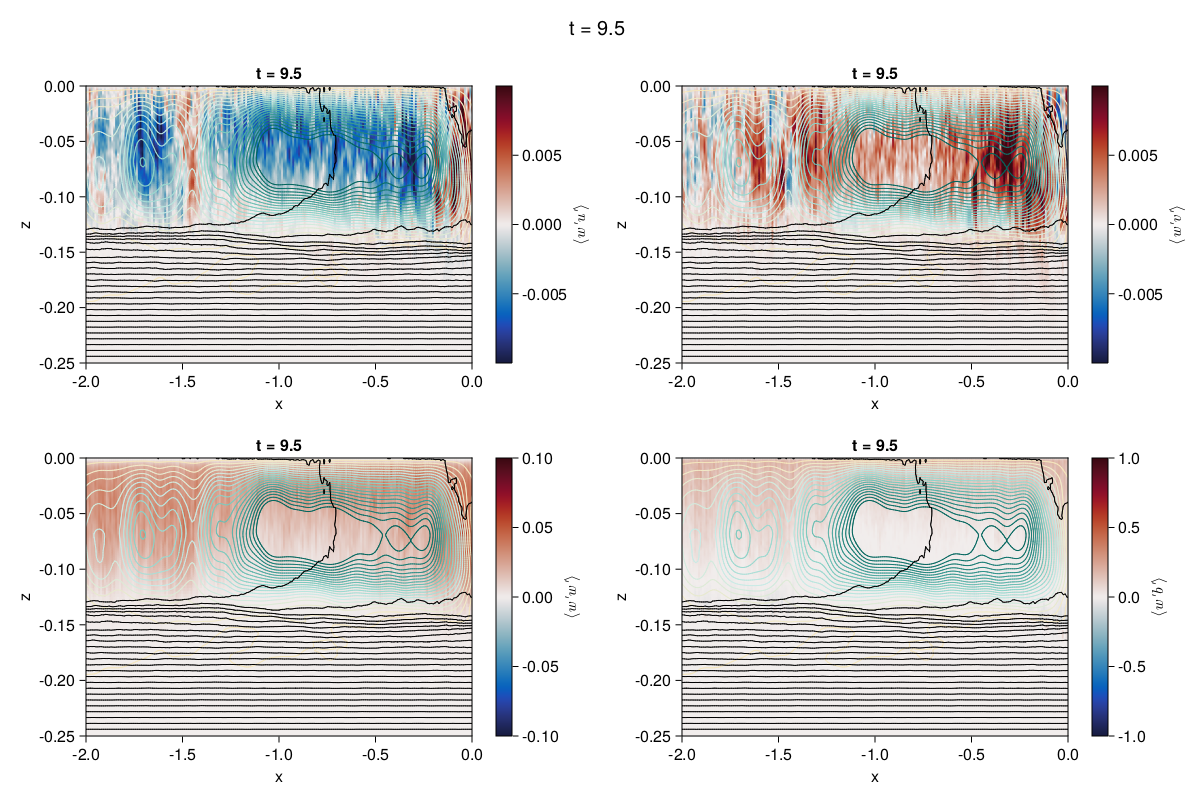

In [85]:
makefluxvid("Ro1Ri02Ek1", 1051)

In [75]:
runname = "default"
@inline function getfluxplot(runname)
    foldername = "../scratch/filament-instability/$runname"
    filename = "down_front_mean.jld2"
    fluxfilename = "turbulent_flux.jld2"
    paramfilename = "parameters.jld2"
    frames, grid = jldopen("$foldername/$filename") do file
        keys(file["timeseries/t"]), file["serialized/grid"]
        end;
    xᶜᵃᵃ = xnodes(Center, grid)
    xᶠᵃᵃ = xnodes(Face, grid)
    zᵃᵃᶜ = znodes(Center, grid)
    zᵃᵃᶠ = znodes(Face, grid)

    file = jldopen("$foldername/$filename")
    fluxfile = jldopen("$foldername/$fluxfilename")

    ts = [file["timeseries/t/$frame"] for frame in frames] .- 30
    
    uflux = [sqrt.(mean(fluxfile["timeseries/uFLUX/$frame"].^2, dims=1)[1, 1, :]) for frame in frames]
    vflux = [sqrt.(mean(fluxfile["timeseries/vFLUX/$frame"].^2, dims=1)[1, 1, :]) for frame in frames]
    wflux = [sqrt.(mean(fluxfile["timeseries/wFLUX/$frame"].^2, dims=1)[1, 1, :]) for frame in frames]
    bflux = [sqrt.(mean(fluxfile["timeseries/bFLUX/$frame"].^2, dims=1)[1, 1, :]) for frame in frames]
    b = -[sqrt.(mean(file["timeseries/b_dfm/$frame"].^2, dims=1)[1, 1, :]) for frame in frames]
    N² = [let out=diff(a) ./ diff(zᵃᵃᶜ); vcat(out[1:2], out) end for a in b]
    
    κ = [sqrt.(mean(fluxfile["timeseries/bFLUX/$frame"].^2)) for frame in frames] ./ ([(b[i][end-10] - b[i][50]) / abs(zᵃᵃᶠ[end-10] - zᵃᵃᶠ[50]) for i in 1:length(frames)])
    return (zᵃᵃᶠ, uflux, vflux, wflux, bflux, b, κ, N²)
end

getfluxplot (generic function with 1 method)

In [76]:
zᵃᵃᶠ, uflux, vflux, wflux, bflux, b, κ, N² = getfluxplot("Ro1Ri02Ek1");

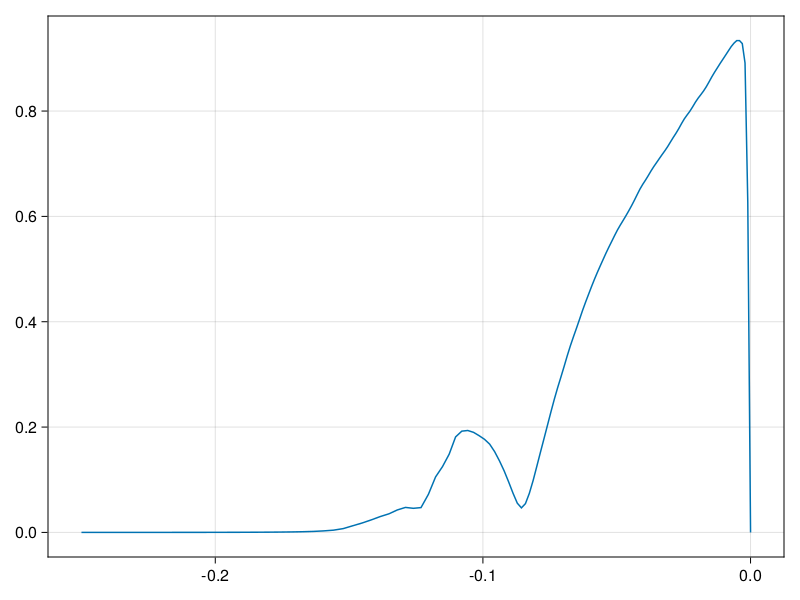

In [80]:
lines(zᵃᵃᶠ, bflux[101] ./ (4.31^2 * 0.1^2))

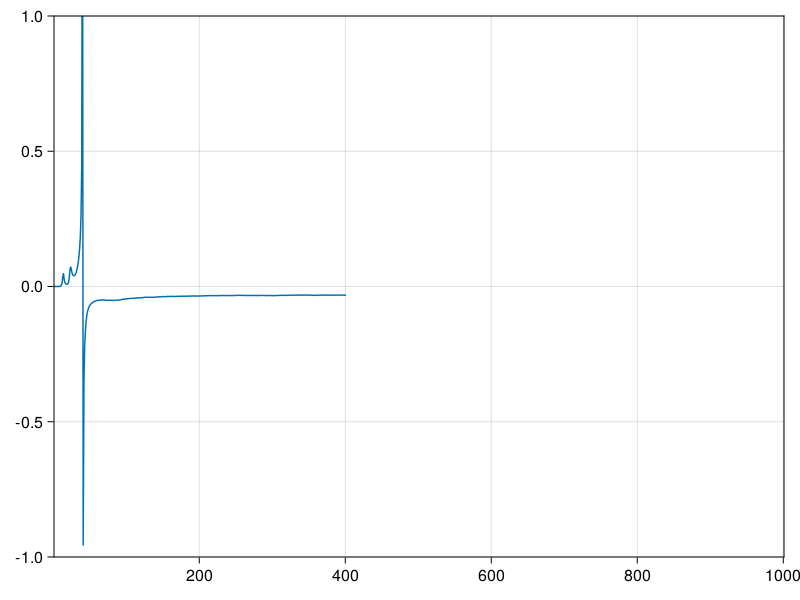

In [58]:
κ₀ = mean(κ[500:end])
fig = Figure()
ax = Axis(fig[1, 1]; limits=(1, 1001, -1, 1))
lines!(ax, κ)
lines!(ax, [1, 1001], [κ₀, κ₀]; color=:orange, style=:-)
fig

In [ ]:
fig = Figure()
ax = Axis(fig[1, 1]; limits=(-150, -100, -0.15, 0))
lines!(ax, b[1], zᵃᵃᶠ[1:128])
lines!(ax, b[61], zᵃᵃᶠ[1:128])
#lines!(ax, b[41], zᵃᵃᶠ[1:128])
#lines!(ax, b[61], zᵃᵃᶠ[1:128])
#lines!(ax, b[81], zᵃᵃᶠ[1:128])
#lines!(ax, b[101], zᵃᵃᶠ[1:128])
fig

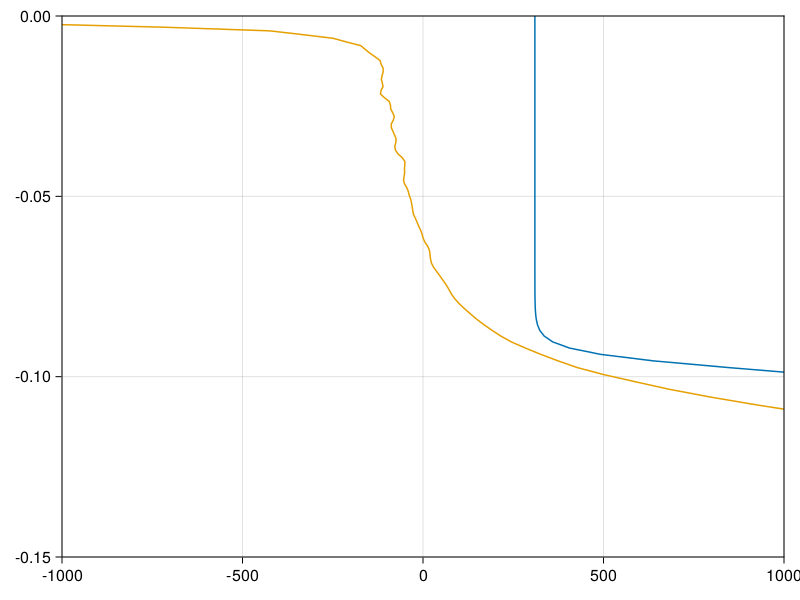

In [59]:
fig = Figure()
ax = Axis(fig[1, 1]; limits=(-1000, 1000, -0.15, 0))
lines!(ax, N²[1], zᵃᵃᶠ)
#lines!(ax, N²[21], zᵃᵃᶠ)
#lines!(ax, N²[41], zᵃᵃᶠ)
#lines!(ax, N²[61], zᵃᵃᶠ)
lines!(ax, N²[61], zᵃᵃᶠ)
fig

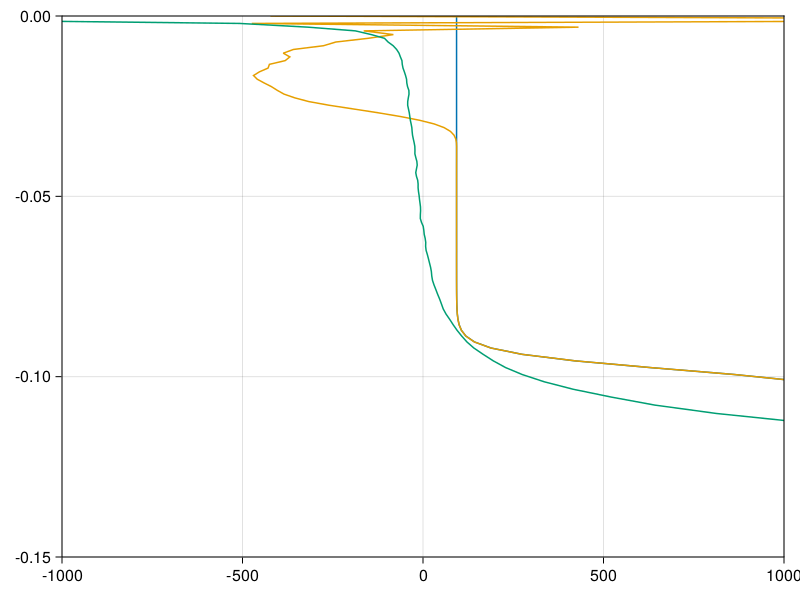

In [100]:
fig = Figure()
ax = Axis(fig[1, 1]; limits=(-1000, 1000, -0.15, 0))
lines!(ax, N²[1], zᵃᵃᶠ)
#lines!(ax, N²[21], zᵃᵃᶠ)
#lines!(ax, N²[41], zᵃᵃᶠ)
#lines!(ax, N²[61], zᵃᵃᶠ)
lines!(ax, N²[20], zᵃᵃᶠ)
lines!(ax, N²[101], zᵃᵃᶠ)
fig

In [105]:
@inline function Ek(runname)
    foldername = "../scratch/filament-instability/$runname"
    filename = "down_front_mean.jld2"
    fluxfilename = "turbulent_flux.jld2"
    paramfilename = "parameters.jld2"
    frames, grid = jldopen("$foldername/$filename") do file
        keys(file["timeseries/t"]), file["serialized/grid"]
        end;
    frame = frames[end]
    xᶜᵃᵃ = xnodes(Center, grid)
    xᶠᵃᵃ = xnodes(Face, grid)
    zᵃᵃᶜ = znodes(Center, grid)
    zᵃᵃᶠ = znodes(Face, grid)

    file = jldopen("$foldername/$filename")
    fluxfile = jldopen("$foldername/$fluxfilename")
    
    uflux = sqrt.(mean(fluxfile["timeseries/uFLUX/$frame"].^2, dims=1)[1, 1, :])
    vflux = sqrt.(mean(fluxfile["timeseries/vFLUX/$frame"].^2, dims=1)[1, 1, :])
    wflux = sqrt.(mean(fluxfile["timeseries/wFLUX/$frame"].^2, dims=1)[1, 1, :])
    bflux = sqrt.(mean(fluxfile["timeseries/bFLUX/$frame"].^2, dims=1)[1, 1, :])
    
    v = cat([0, 0], diff(mean(file["timeseries/v_dfm/$frame"].^2, dims=1)[1, 1, :]) ./ diff(zᵃᵃᶜ), dims=1)
    
    close(file)
    close(fluxfile)
    return (zᵃᵃᶠ, uflux, vflux, wflux, bflux, v)
end

Ek (generic function with 1 method)

In [126]:
(zᵃᵃᶠ, uflux, vflux, wflux, bflux, v) = Ek("cooling2");

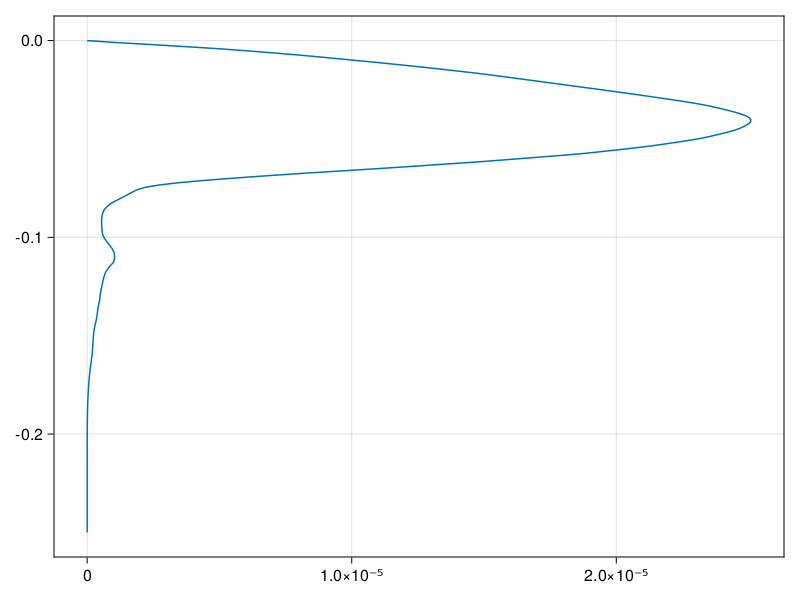

In [127]:
lines(vflux./(v.+0.1), zᵃᵃᶠ)

In [119]:
maximum(wflux)^(3/2) * zᵃᵃᶠ[argmax(wflux)]

-2.3072009053809016e-9

In [121]:
maximum(wflux)^(3/2) * zᵃᵃᶠ[argmax(wflux)]

-5.0915862256978366e-6